# Testing the performance of a Language Model (LM) on annotated dataset




## Installs

Installation of **[transformers](https://github.com/huggingface/transformers)** and **[ml_things](https://github.com/gmihaila/ml_things)**.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 10.8 MB/s 
     |████████████████████████████████| 182 kB 54.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 9.4 MB 30.0 MB/s 
     |████████████████████████████████| 965 kB 57.1 MB/s 
     |████████████████████████████████| 295 kB 76.1 MB/s 


Install matplotlib 3.1.3

In [2]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 13.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency 

## Imports

Import necessary libraries



In [1]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

## Declaration of parameters


Declare parameters used in this notebook

In [2]:
# Set seed for reproducibility
set_seed(123)


# Number of batch_size - depending on the max sequence length and avaialable GPU memory
# For 512 sequence length batch of 10 works without cuda memory issues
# For small sequence length one can try batch of 32 or higher
batch_size = 16


# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model
max_length = None

# Look for gpu to use. Will use `cpu` by default if no gpu found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of the transformers model - will use already pretrained model
# Path of transformer model - will load your own model from local disk

model_name_or_path = "Rewire/XTC"
#model_name_or_path = "/content/drive/MyDrive/XTC"

# Dictionary of labels and their ids 
# this will be used to convert string labels to number.
labels_ids = {'non-hate': 0, 'hate': 1}

# How many labels are we using in training
# This is used to decide the size of the classification head
n_labels = len(labels_ids)

## Load the test dataset (annotated in LabelStudio)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset(s)

In [29]:
#---- multilingual hatecheck test suites---------------
os.chdir("/content/drive/MyDrive/")
test = pd.read_csv("project-10-at-2022-12-20-11-34-4607adba.csv")


print ("Size of annotation test dataset-->", len(test))

Size of annotation test dataset--> 115


Preparing the test dataset

In [30]:
test.columns

Index(['message', 'messageSentiment.score', 'messageHate.score', 'id',
       'sentiment', 'annotator', 'annotation_id', 'created_at', 'updated_at',
       'lead_time'],
      dtype='object')

In [31]:
print (test.sample(10))

                                               message  \
85                        सुलेमानी कीड़ा जग गया होगा...   
88                                  Indian secularism.   
42   अगर देश के मुसलमानों ने अपना आदर्श डॉक्टर कलाम...   
82   370 हटने के बाद कश्मीर में अब जो शांति है ,शान...   
94   MERA BHARAT MAHAN-NAMO NAMO NAMAMI-JAI HIND JA...   
90                                                  😂😂   
100                   धोबी का कु... ना घर का ना घाट...   
13   हर हर महादेव 🙏 पेज को जरूर फॉलो करें🙏 दुनिया क...   
59   इस्लामिक जिहादियों ने फिर पार कीं क्रूरता की ह...   
111                                      #AkhandBharat   

     messageSentiment.score  messageHate.score     id           sentiment  \
85                        0                  1  32532             Hateful   
88                        0                  1  32386         Non-hateful   
42                        0                  1  31861  negative discourse   
82                        0                  1  31828

Select and rename only relevant columns

In [32]:
test = test [['message', 'sentiment']]

test = test.rename(columns={'message': 'text', 'sentiment': 'label'})

In [35]:
test = test.replace({'negative discourse': 'Negative discourse', 'needs more context': 'Insufficient context'})

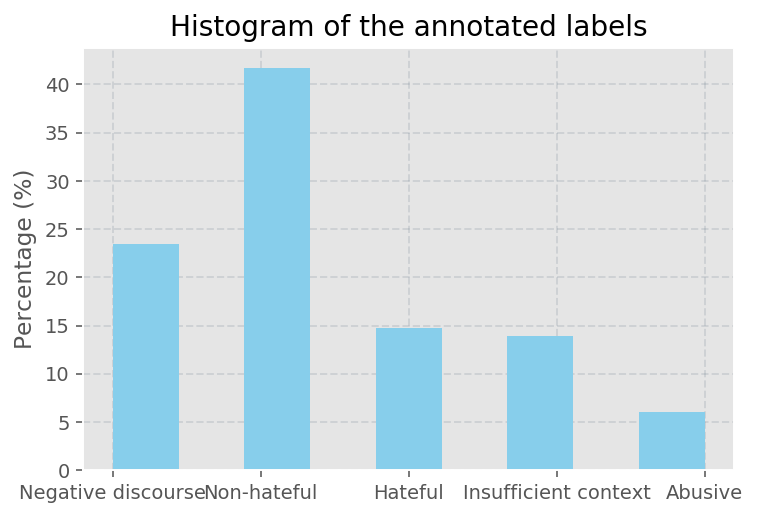

In [36]:
x = np.arange(5)
bins = np.linspace(0, 4, 10)

fig, ax = plt.subplots (figsize=(6, 4), dpi=140)
plt.title ('Histogram of the annotated labels')

test['label'].hist(bins=bins, weights=np.ones_like(test[test.columns[0]])*100./len(test), color = "skyblue")

ax.set_ylabel ('Percentage (%)')
#ax.set_xlabel (r'Predicted labels')
ax.set_xticks (x)
#ax.set_xticklabels (list(labels_ids_sentiment.keys()))
ax.grid(color='slategrey', linestyle='--', linewidth=1, alpha=0.2)
#ax.legend (loc='upper right')
plt.show ()

Choose only the hate and non-hate labels

In [37]:
test = test [ (test['label'] == 'Non-hateful') | (test['label'] == 'Hateful')]
test = test.replace({'Hateful': 1, 'Non-hateful': 0})

#print (len(test))
print (test.head(20))

65
                                                 text  label
1   Attended the 5th meeting of NITI Aayog’s Gover...      0
2   जला तो दिया तुमने निर्दोष पुजारी बाबा को कल को...      1
4   भारतभूमि में जन्में सभी पंथ एवं सम्प्रदायों के...      0
5   अयोध्या के श्री राम जी का भव्य मन्दिर का निर्म...      0
8   फिल्म में होंगे मोदी के चाय बेचने से लेकर कैंट...      0
16  दीपा मलिक भारतीय पैरालम्पिक खिलाड़ियों की जीत ...      0
19  पाकिस्तान से आए हिंदू सरणार्थी साउथ दिल्ली के ...      0
22  # मोडलींग छोड़िये # अपनी हिन्दू संस्कृति के अन...      0
23  ओलिंपिक में ब्रॉन्ज मेडल जीतने वाली भारतीय हॉक...      0
24  उत्तर प्रदेश के इस शहर में है अनुष्का और विराट...      0
25  महाराज की सम्पत्ति जानकार अम्बानी-अडानी को भी ...      0
28  आतंकवाद और कश्मीरी पंडितों की हत्या के मामले म...      0
30                     कांग्रेस वाले पागल हो चुके है।      0
32  राष्ट्रपिता महात्मा गांधी जी की पुण्यतिथि पर उ...      0
34  अभी जो राज्य सरकारें 3 मई के बाद भी केंद्र सरक...      0
35  सचिन तेंदुलकर की 

Extract testing texts and labels

In [18]:
test_text = list(test ['text'])
test_labels = list(test ['label'])

## Define helper class and functions

Classes and functions that are used in this notebook:

* MyDataset

* validation

Define `MyDatset` class

In [20]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

**Define `validation` function:**

Validation function to evaluate model performance on a separate set of data. This function will return the true and predicted labels so we can use later to evaluate the model's performance.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]


In [21]:
def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## Load config, tokenizer and the model

Loading the three esential parts of pretrained transformers: 

* configuration, 
* tokenizer and 
* model. 

We also need to load the model to the device we're planning to use (GPU / CPU).

In [22]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

Loading model configuraiton...


Downloading:   0%|          | 0.00/741 [00:00<?, ?B/s]

Loading model tokenizer...


Downloading:   0%|          | 0.00/358 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loading the model...


Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model loaded to `cuda`


## Data encoding and create DataLoader object

Create data encodings

In [23]:
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

test_dataset = MyDataset(test_encodings, test_labels)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Create DataLoader objects that will be fed into our model

In [24]:
test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

Created `test_dataloader` with 5 batches!


## Evaluation on the annotated test dataset



  0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    non-hate       1.00      0.71      0.83        48
        hate       0.55      1.00      0.71        17

    accuracy                           0.78        65
   macro avg       0.77      0.85      0.77        65
weighted avg       0.88      0.78      0.80        65

Normalized confusion matrix


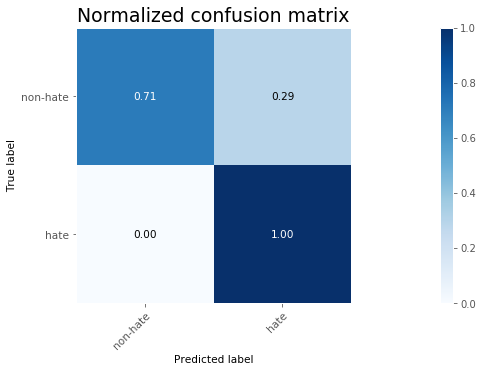

In [25]:
# Get model predictions on the test data
true_labels, predictions_labels, avg_epoch_loss = validation (test_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report (true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Print the evaluation report
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1, 
                      use_title='Normalized confusion matrix'
                      );

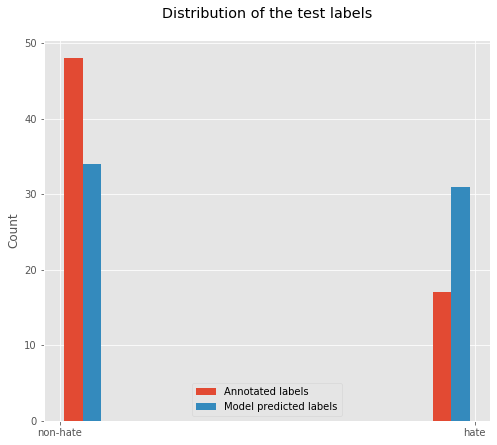

In [26]:
x = np.arange(n_labels)
bins = np.linspace(0, 1, 10)

fig, ax = plt.subplots(figsize=(8, 7))
plt.title('Distribution of the test labels\n')
plt.hist([true_labels, predictions_labels], bins, label=['Annotated labels', 'Model predicted labels'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower center')
plt.show()